In [263]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.envs.make('MountainCar-v0')
env._max_episode_steps = 2000

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
from IPython.core.debugger import set_trace

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
cuda


## Replay Memory

In [264]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Model Definition

In [265]:
class NeuralNet(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        """
        In the constructor we instantiate 3 nn.Linear modules and assign them as
        member variables.
        """
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h1_relu = F.relu(self.linear1(x))
        h2_relu = F.relu(self.linear2(h1_relu))
        y_pred = self.linear3(h2_relu)
        return y_pred

## Training
This cell defines model's optimizer & hyper parameter

In [266]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 700
TARGET_UPDATE = 5  # 5

D_in, H1, H2, D_out = 4, 256, 256, 3

policy_net = NeuralNet(D_in, H1, H2, D_out).to(device)
target_net = NeuralNet(D_in, H1, H2, D_out).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest value for column of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []

In [267]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
#     print("state_action_values:\n", state_action_values)
#     print("--------------------------------------")
#     print("expected_state_action_values:\n", expected_state_action_values)
#     print("--------------------------------------")
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1), reduction='sum')
#     loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1), reduction='sum')
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss

### Training loop

In [268]:
num_episodes = 100
for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = np.append(obs, np.square(obs))
    state = torch.tensor(obs.reshape((1, 4)), device=device, dtype=torch.float)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        new_obs, reward, done, _ = env.step(action.item())
        
        if new_obs[0] > 0.45:
            reward = 1.
            done = True
        
        reward = torch.tensor([reward], device=device)

        # Observe new state
        if not done:
            new_obs = np.append(new_obs, np.square(new_obs))
            next_state = torch.tensor(new_obs.reshape((1, 4)), device=device, dtype=torch.float)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        if t % 500 == 0 and t > 0:
            print("Episode %d:\tloss = %f" % (i_episode, loss))
        if done:
            episode_durations.append(t + 1)
#             plot_durations()
            print("Episode %d finishes after %d steps" % (i_episode, t+1))
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


Episode 0:	loss = 0.163904
Episode 0:	loss = 0.004019
Episode 0:	loss = 0.012623
Episode 0 finishes after 2000 steps
Episode 1:	loss = 0.058467
Episode 1:	loss = 0.021826
Episode 1:	loss = 0.006113
Episode 1 finishes after 2000 steps
Episode 2:	loss = 0.014074
Episode 2:	loss = 0.008622
Episode 2:	loss = 0.000071
Episode 2 finishes after 2000 steps
Episode 3:	loss = 0.000115
Episode 3:	loss = 0.007452
Episode 3:	loss = 0.000129
Episode 3 finishes after 2000 steps
Episode 4:	loss = 0.014917
Episode 4:	loss = 0.000196
Episode 4:	loss = 0.004605
Episode 4 finishes after 2000 steps
Episode 5:	loss = 0.000226
Episode 5:	loss = 0.000651
Episode 5:	loss = 0.001975
Episode 5 finishes after 2000 steps
Episode 6:	loss = 0.001143
Episode 6:	loss = 0.001991
Episode 6:	loss = 0.002015
Episode 6 finishes after 2000 steps
Episode 7:	loss = 0.000815
Episode 7:	loss = 0.005591
Episode 7:	loss = 0.000125
Episode 7 finishes after 2000 steps
Episode 8:	loss = 0.000133
Episode 8:	loss = 0.000179
Episode 8:

Episode 68:	loss = 0.048096
Episode 68:	loss = 0.145741
Episode 68 finishes after 2000 steps
Episode 69:	loss = 0.001858
Episode 69:	loss = 0.024788
Episode 69:	loss = 0.005173
Episode 69 finishes after 2000 steps
Episode 70:	loss = 0.000195
Episode 70:	loss = 0.285384
Episode 70:	loss = 0.000450
Episode 70 finishes after 2000 steps
Episode 71:	loss = 0.000432
Episode 71:	loss = 0.000238
Episode 71:	loss = 0.000461
Episode 71 finishes after 2000 steps
Episode 72:	loss = 0.007111
Episode 72:	loss = 0.000606
Episode 72 finishes after 1463 steps
Episode 73:	loss = 0.041525
Episode 73:	loss = 0.021555
Episode 73:	loss = 0.012217
Episode 73 finishes after 2000 steps
Episode 74:	loss = 0.002695
Episode 74:	loss = 0.012709
Episode 74:	loss = 0.020274
Episode 74 finishes after 2000 steps
Episode 75:	loss = 0.003702
Episode 75:	loss = 0.162799
Episode 75:	loss = 0.001979
Episode 75 finishes after 2000 steps
Episode 76:	loss = 0.002609
Episode 76:	loss = 0.008301
Episode 76:	loss = 0.029919
Epis

## Utilities

In [271]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)  # pause a bit so that plots are updated
#     if is_ipython:
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
    plt.show()

        
def plot_value_func():
    x_vect = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=50)
    xdot_vect = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=50)
    x, xdot = np.meshgrid(x_vect, xdot_vect)
    state_value = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            state = np.array([x[i, j], xdot[i, j], (x[i, j])**2, (xdot[i, j])**2])
            state = torch.tensor(state.reshape((1, 4)), device=device, dtype=torch.float)  
            action_value_tensor = target_net(state)
            action_value_list = action_value_tensor.tolist()[0]
            state_value[i, j] = max(action_value_list)
    # plot Value function
    fig = plt.figure(3)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, xdot, -state_value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    plt.show()

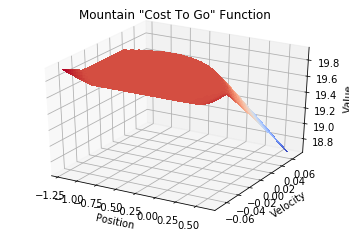

In [272]:
plot_value_func()

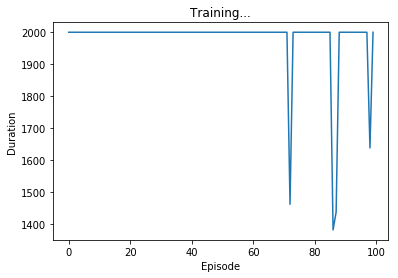

In [270]:
plot_durations()